# Bangladeshi Mango Leaf Classification with Ensemble Methods


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split # Changed this line
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from torch.utils.data import Subset

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 1. Data Preparation & Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# ------------------------------------------
# Data Loader Configuration
# ------------------------------------------
data_dir = '/content/drive/MyDrive/Image_Dataset of_Bangladeshi_Mango_Leaf/Original'
img_size = 224
batch_size = 32

In [11]:
# %%
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

print("Number of classes:", num_classes)
print("Class names:", class_names)



Number of classes: 6
Class names: ['Amrapali Mango', 'Banana Mango', 'Chaunsa Mango', 'Fazli Mango', 'Haribhanga Mango', 'Himsagar Mango']


In [12]:
# %%
# Stratified split (80-10-10)
train_idx, temp_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[full_dataset.targets[i] for i in temp_idx],
    random_state=42
)

# Create subsets with different transforms
train_set = Subset(full_dataset, train_idx)
val_set = Subset(full_dataset, val_idx)
test_set = Subset(full_dataset, test_idx)

# Apply different transforms to validation/test
val_set.dataset.transform = val_test_transform
test_set.dataset.transform = val_test_transform

# Create dataloaders
# Create dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [13]:
# %%
# Verify splits
def print_split_stats(name, dataset, full_length):
    print(f"{name}: {len(dataset)} samples ({len(dataset)/full_length:.1%})")
    class_counts = {class_names[i]:0 for i in range(num_classes)}
    for _, label in dataset:
        class_counts[class_names[label]] += 1
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")

print_split_stats("Training set", train_set, len(full_dataset))
print_split_stats("Validation set", val_set, len(full_dataset))
print_split_stats("Test set", test_set, len(full_dataset))

Training set: 669 samples (79.9%)
  Amrapali Mango: 96
  Banana Mango: 133
  Chaunsa Mango: 120
  Fazli Mango: 128
  Haribhanga Mango: 96
  Himsagar Mango: 96
Validation set: 84 samples (10.0%)
  Amrapali Mango: 12
  Banana Mango: 17
  Chaunsa Mango: 15
  Fazli Mango: 16
  Haribhanga Mango: 12
  Himsagar Mango: 12
Test set: 84 samples (10.0%)
  Amrapali Mango: 12
  Banana Mango: 17
  Chaunsa Mango: 15
  Fazli Mango: 16
  Haribhanga Mango: 12
  Himsagar Mango: 12


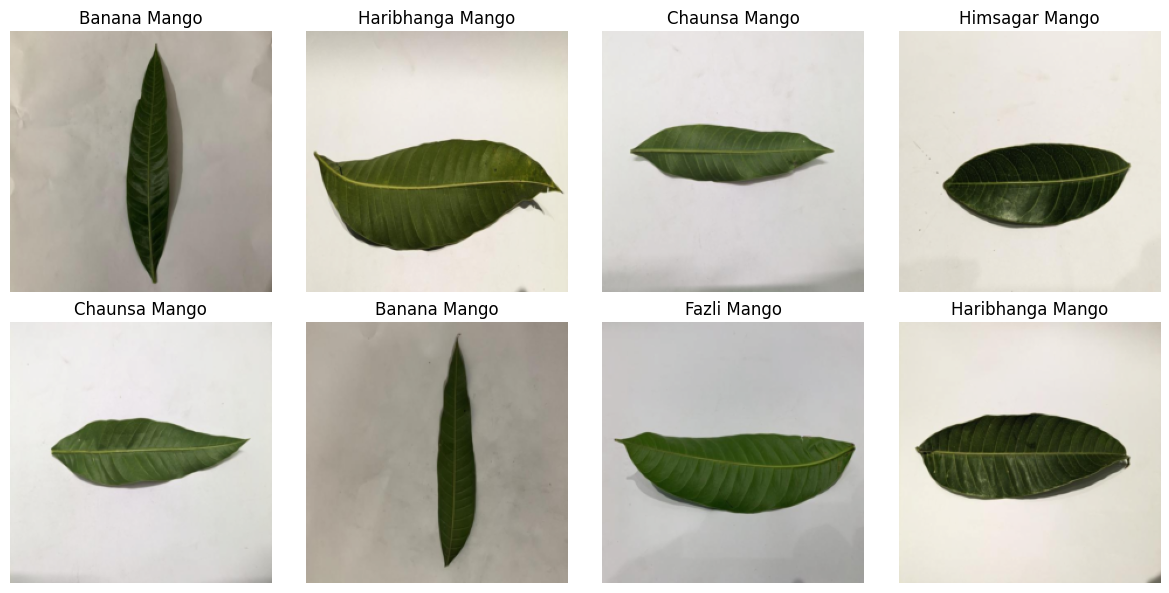

In [14]:
# %%
def plot_batch(loader, classes):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12,6))
    for i in range(min(8, len(images))):
        img = images[i].permute(1,2,0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
        img = np.clip(img, 0, 1)
        plt.subplot(2,4,i+1)
        plt.imshow(img)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_batch(train_loader, class_names)

## 2. Baseline Model Development

In [15]:
# %%
class MangoCNN(nn.Module):
    def __init__(self, num_classes):
        super(MangoCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [18]:
def train_model(model, criterion, optimizer, epochs=50, patience=10):
    best_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_set)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_set)
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")

        """# Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict()  # Save best model state
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                if best_state is not None:
                    model.load_state_dict(best_state)  # Restore best state
                break"""

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model_without_ES.pth')

    return history

In [19]:
# %%
# Initialize model
model = MangoCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
history = train_model(model, criterion, optimizer, epochs=50)

Epoch 1/50
----------
Train Loss: 2.0958 Acc: 0.2616
Val Loss: 1.5300 Acc: 0.4643

Epoch 2/50
----------
Train Loss: 1.4136 Acc: 0.4484
Val Loss: 1.2670 Acc: 0.5952

Epoch 3/50
----------
Train Loss: 1.1268 Acc: 0.5575
Val Loss: 1.0162 Acc: 0.6429

Epoch 4/50
----------
Train Loss: 0.7923 Acc: 0.6966
Val Loss: 0.7757 Acc: 0.7262

Epoch 5/50
----------
Train Loss: 0.6179 Acc: 0.7698
Val Loss: 0.7462 Acc: 0.7262

Epoch 6/50
----------
Train Loss: 0.3959 Acc: 0.8386
Val Loss: 0.7372 Acc: 0.7500

Epoch 7/50
----------
Train Loss: 0.3280 Acc: 0.8759
Val Loss: 0.6109 Acc: 0.7976

Epoch 8/50
----------
Train Loss: 0.2561 Acc: 0.9178
Val Loss: 0.8806 Acc: 0.7381

Epoch 9/50
----------
Train Loss: 0.2297 Acc: 0.9118
Val Loss: 0.8284 Acc: 0.7857

Epoch 10/50
----------
Train Loss: 0.1685 Acc: 0.9387
Val Loss: 0.8132 Acc: 0.7976

Epoch 11/50
----------
Train Loss: 0.1178 Acc: 0.9581
Val Loss: 0.8613 Acc: 0.7857

Epoch 12/50
----------
Train Loss: 0.1249 Acc: 0.9581
Val Loss: 0.9979 Acc: 0.7738

E

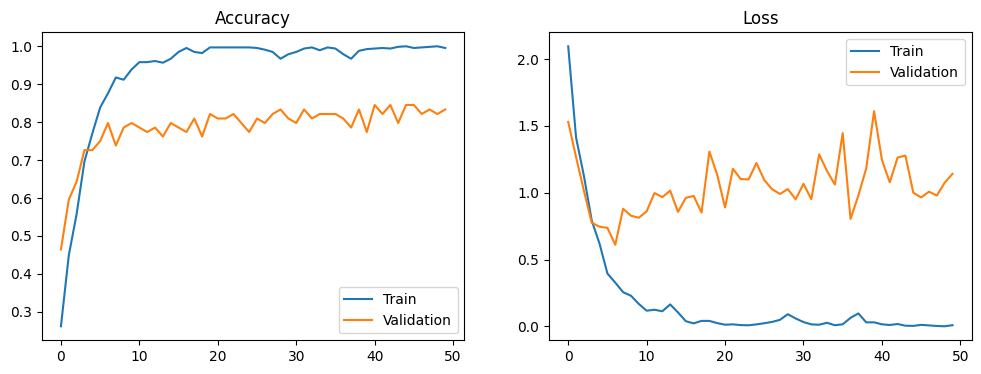

In [20]:
# %%
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [21]:
# %%
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds

# Load best model
model.load_state_dict(torch.load('best_model_without_ES.pth'))
test_labels, test_preds = evaluate_model(model, test_loader)

# %%
print("Baseline Model Performance:")
print(classification_report(test_labels, test_preds, target_names=class_names))

Baseline Model Performance:
                  precision    recall  f1-score   support

  Amrapali Mango       0.56      0.42      0.48        12
    Banana Mango       0.82      0.82      0.82        17
   Chaunsa Mango       0.88      1.00      0.94        15
     Fazli Mango       0.94      0.94      0.94        16
Haribhanga Mango       1.00      0.83      0.91        12
  Himsagar Mango       0.73      0.92      0.81        12

        accuracy                           0.83        84
       macro avg       0.82      0.82      0.82        84
    weighted avg       0.83      0.83      0.83        84



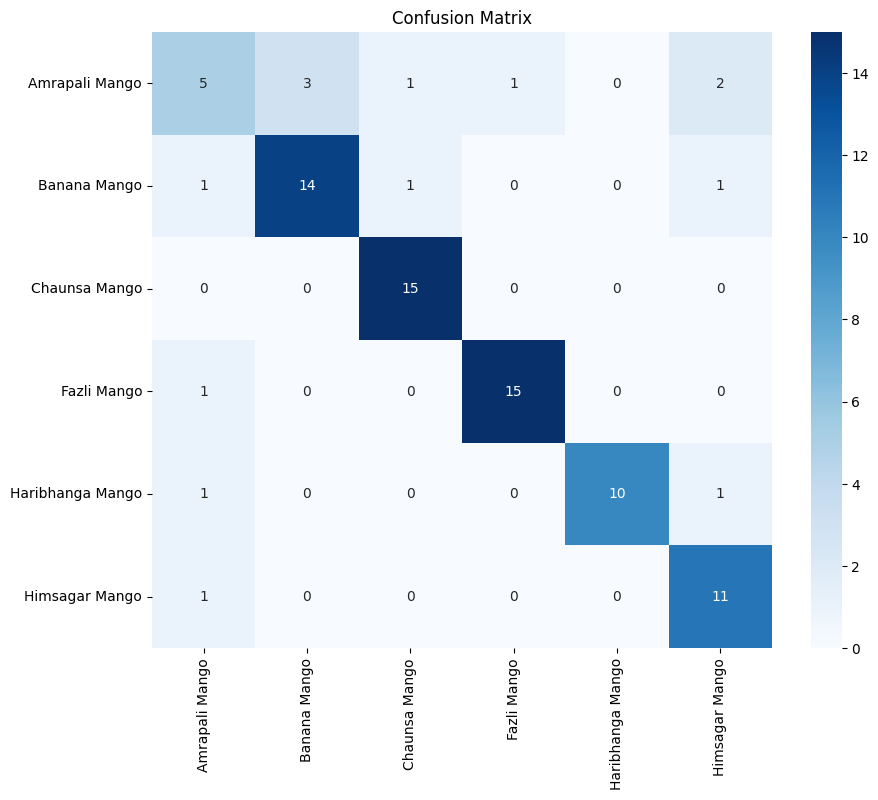

In [22]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

## 3. Ensemble Methods Implementation
# <span style="color:green;background-color:#e6ffe6;padding:5px">Implementing Bagging, Boosting, and Stacking</span>

In [23]:
!pip install scipy
# %%
!pip install colorama
from colorama import Fore, Back, Style
import sys

In [24]:
class ColorLogger:
    @staticmethod
    def info(msg):
        print(Fore.CYAN + "[INFO] " + Style.RESET_ALL + msg)

    @staticmethod
    def success(msg):
        print(Fore.GREEN + "[SUCCESS] " + Style.RESET_ALL + msg)

    @staticmethod
    def warning(msg):
        print(Fore.YELLOW + "[WARNING] " + Style.RESET_ALL + msg)

    @staticmethod
    def model_status(msg):
        print(Fore.MAGENTA + "[MODEL] " + Style.RESET_ALL + msg)

### 3.1 Bagging Implementation
# <span style="color:blue;background-color:#e6f3ff;padding:5px">
# Strategy: Train multiple independent models on bootstrap samples of the training data
# </span>

In [25]:
# %%
from scipy.stats import mode
import numpy as np
from sklearn.metrics import classification_report

# Fix worker warning
NUM_WORKERS = min(os.cpu_count(), 2)  # Add this at the top

In [26]:
# %%
class BaggingEnsemble:
    def __init__(self, num_models=3, patience=10):
        self.num_models = num_models
        self.models = [MangoCNN(num_classes).to(device) for _ in range(num_models)]
        self.patience = patience

    def train(self):
        ColorLogger.info("Training Bagging Ensemble\n" + "="*40)
        for i, model in enumerate(self.models):
            model_name = f"MangoCNN_{i+1}"
            ColorLogger.model_status(f"Training Model {i+1}/{self.num_models} ({model_name})")
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()

            best_val_loss = float('inf')
            patience_counter = 0
            best_state = None

            # Create bootstrap sample with proper worker count
            indices = torch.randint(0, len(train_set), (len(train_set),))
            bootstrap_loader = DataLoader(
                Subset(train_set, indices),
                batch_size=batch_size,
                shuffle=True,
                num_workers=NUM_WORKERS
            )

            # Train model with progress tracking
            model.train()
            for epoch in range(50):
                total_loss = 0
                correct = 0
                total = 0

                for inputs, labels in bootstrap_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                epoch_acc = correct / total
                ColorLogger.info(f"Model {i+1} ({model_name}) Epoch {epoch+1}: Loss {total_loss/total:.4f} | Acc {epoch_acc:.2%}")

                """# Early stopping check
                val_loss = self.evaluate(model, val_loader, criterion)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_state = model.state_dict()  # Save best model state
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print(f"Early stopping triggered for {model_name} after {epoch+1} epochs")
                        if best_state is not None:
                            model.load_state_dict(best_state)  # Restore best state
                        break"""

    def evaluate(self, model, loader, criterion):
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        return val_loss / len(loader.dataset)

    def predict(self, loader):
        ColorLogger.info("Making Bagging Predictions")
        all_preds = []

        for model in self.models:
            model.eval()
            model_preds = []
            with torch.no_grad():
                for inputs, _ in loader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    model_preds.extend(preds.cpu().numpy())
            all_preds.append(model_preds)

        # Proper majority voting
        arr = np.array(all_preds)
        majority_vote, _ = mode(arr, axis=0)
        return majority_vote.flatten()  # Fix shape for classification report

# Verify implementation
print("\n" + "="*40)
ColorLogger.success("Running Corrected Bagging Implementation")
bagging = BaggingEnsemble(num_models=3)
bagging.train()

# %%
# Test prediction with shape verification
bagging_preds = bagging.predict(test_loader)
ColorLogger.info(f"Predictions shape: {np.array(bagging_preds).shape}")
ColorLogger.info(f"Test labels shape: {len(test_labels)}")

# %%
# Safe classification report
try:
    bagging_acc = np.mean(bagging_preds == test_labels)
    ColorLogger.success(f"Bagging Accuracy: {bagging_acc:.2%}")
    print(classification_report(test_labels, bagging_preds, target_names=class_names))
except Exception as e:
    ColorLogger.warning(f"Error in classification: {str(e)}")
    print("Predictions:", np.unique(bagging_preds, return_counts=True))
    print("True labels:", np.unique(test_labels, return_counts=True))


[SUCCESS] Running Corrected Bagging Implementation
[INFO] Training Bagging Ensemble
[MODEL] Training Model 1/3 (MangoCNN_1)
[INFO] Model 1 (MangoCNN_1) Epoch 1: Loss 0.0775 | Acc 25.86%
[INFO] Model 1 (MangoCNN_1) Epoch 2: Loss 0.0409 | Acc 48.43%
[INFO] Model 1 (MangoCNN_1) Epoch 3: Loss 0.0271 | Acc 67.26%
[INFO] Model 1 (MangoCNN_1) Epoch 4: Loss 0.0199 | Acc 77.13%
[INFO] Model 1 (MangoCNN_1) Epoch 5: Loss 0.0155 | Acc 82.51%
[INFO] Model 1 (MangoCNN_1) Epoch 6: Loss 0.0102 | Acc 87.74%
[INFO] Model 1 (MangoCNN_1) Epoch 7: Loss 0.0063 | Acc 92.53%
[INFO] Model 1 (MangoCNN_1) Epoch 8: Loss 0.0052 | Acc 94.17%
[INFO] Model 1 (MangoCNN_1) Epoch 9: Loss 0.0057 | Acc 93.57%
[INFO] Model 1 (MangoCNN_1) Epoch 10: Loss 0.0077 | Acc 92.23%
[INFO] Model 1 (MangoCNN_1) Epoch 11: Loss 0.0040 | Acc 96.56%
[INFO] Model 1 (MangoCNN_1) Epoch 12: Loss 0.0024 | Acc 97.46%
[INFO] Model 1 (MangoCNN_1) Epoch 13: Loss 0.0018 | Acc 98.51%
[INFO] Model 1 (MangoCNN_1) Epoch 14: Loss 0.0013 | Acc 99.10%
[I

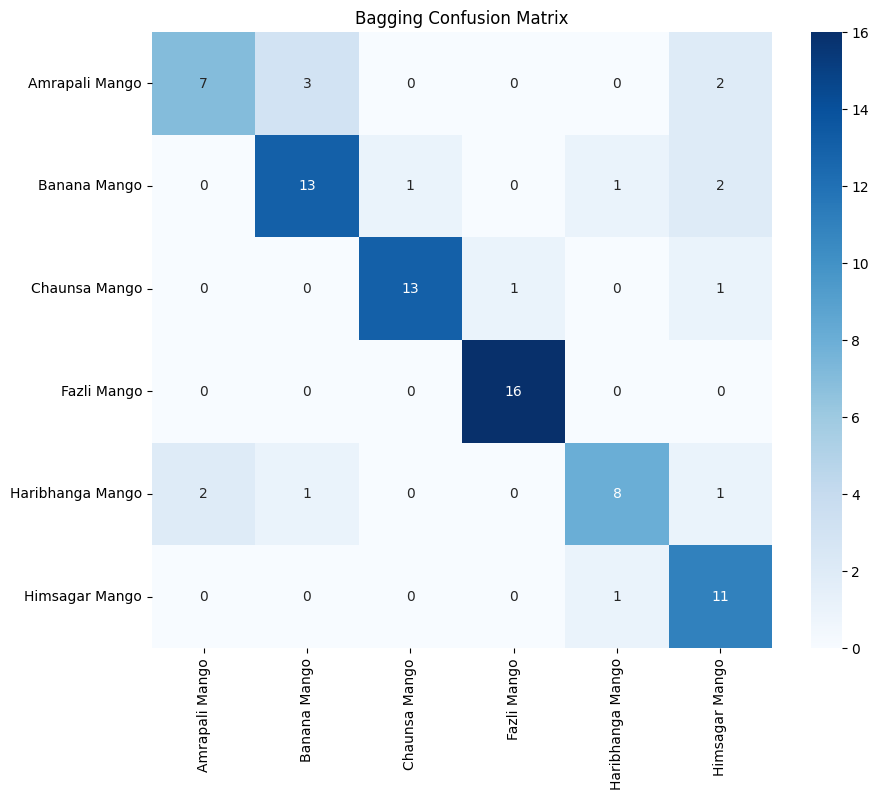

In [27]:
# Confusion matrix
cm = confusion_matrix(test_labels, bagging_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Bagging Confusion Matrix')
plt.show()

### 3.2 Boosting Implementation
# <span style="color:blue;background-color:#e6f3ff;padding:5px">
# Strategy: Sequentially train models focusing on misclassified examples
# </span>

In [28]:
# %%
from sklearn.utils import shuffle

class AdaBoost:
    def __init__(self, num_models=3, patience=10):
        self.models = []
        self.alphas = []
        self.num_models = num_models
        self.sample_weights = None
        self.patience = patience

    def train(self):
        ColorLogger.info("Training AdaBoost Ensemble\n" + "="*40)
        self.sample_weights = np.ones(len(train_set)) / len(train_set)

        for m in range(self.num_models):
            model_name = f"MangoCNN_{m+1}"
            ColorLogger.model_status(f"Training Booster {m+1}/{self.num_models} ({model_name})")

            # Create weighted dataset
            weighted_indices = np.random.choice(
                range(len(train_set)),
                size=len(train_set),
                p=self.sample_weights,
                replace=True
            )

            # Create model and optimizer
            model = MangoCNN(num_classes).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()

            best_val_loss = float('inf')
            patience_counter = 0
            best_state = None

            # Create weighted loader
            weighted_loader = DataLoader(
                Subset(train_set, weighted_indices),
                batch_size=batch_size,
                shuffle=True,
                num_workers=NUM_WORKERS
            )

            # Train model
            model.train()
            for epoch in range(50):
                total_loss = 0
                correct = 0
                total = 0

                for inputs, labels in weighted_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                epoch_acc = correct / total
                ColorLogger.info(f"Booster {m+1} ({model_name}) Epoch {epoch+1}: Loss {total_loss/total:.4f} | Acc {epoch_acc:.2%}")

                """# Early stopping check
                val_loss = self.evaluate(model, val_loader, criterion)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_state = model.state_dict()  # Save best model state
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print(f"Early stopping triggered for {model_name} after {epoch+1} epochs")
                        if best_state is not None:
                            model.load_state_dict(best_state)  # Restore best state
                        break"""

            ColorLogger.success(f"Booster {m+1} Training Complete")
            self.models.append(model)

    def evaluate(self, model, loader, criterion):
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        return val_loss / len(loader.dataset)

    def predict(self, loader):
        ColorLogger.info("Making AdaBoost Predictions")
        all_preds = []

        for model in self.models:
            model.eval()
            model_preds = []
            with torch.no_grad():
                for inputs, _ in loader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    model_preds.extend(preds.cpu().numpy())
            all_preds.append(model_preds)

        # Weighted majority voting
        arr = np.array(all_preds)
        majority_vote, _ = mode(arr, axis=0)
        return majority_vote.flatten()  # Fix shape for classification report

# Verify AdaBoost implementation
print("\n" + "="*40)
ColorLogger.success("Running Corrected AdaBoost Implementation")
adaboost = AdaBoost(num_models=3)
adaboost.train()

# %%
# Test prediction with verification
adaboost_preds = adaboost.predict(test_loader)
ColorLogger.info(f"Predictions shape: {adaboost_preds.shape}")
ColorLogger.info(f"Test labels shape: {len(test_labels)}")

# %%
# Safe classification report
try:
    adaboost_acc = np.mean(adaboost_preds == test_labels)
    ColorLogger.success(f"AdaBoost Accuracy: {adaboost_acc:.2%}")
    print(classification_report(test_labels, adaboost_preds, target_names=class_names))
except Exception as e:
    ColorLogger.warning(f"Error in classification: {str(e)}")
    print("Predictions:", np.unique(adaboost_preds, return_counts=True))
    print("True labels:", np.unique(test_labels, return_counts=True))


[SUCCESS] Running Corrected AdaBoost Implementation
[INFO] Training AdaBoost Ensemble
[MODEL] Training Booster 1/3 (MangoCNN_1)
[INFO] Booster 1 (MangoCNN_1) Epoch 1: Loss 0.0646 | Acc 24.81%
[INFO] Booster 1 (MangoCNN_1) Epoch 2: Loss 0.0444 | Acc 44.99%
[INFO] Booster 1 (MangoCNN_1) Epoch 3: Loss 0.0276 | Acc 68.01%
[INFO] Booster 1 (MangoCNN_1) Epoch 4: Loss 0.0170 | Acc 80.72%
[INFO] Booster 1 (MangoCNN_1) Epoch 5: Loss 0.0141 | Acc 82.81%
[INFO] Booster 1 (MangoCNN_1) Epoch 6: Loss 0.0093 | Acc 89.84%
[INFO] Booster 1 (MangoCNN_1) Epoch 7: Loss 0.0064 | Acc 92.83%
[INFO] Booster 1 (MangoCNN_1) Epoch 8: Loss 0.0052 | Acc 94.17%
[INFO] Booster 1 (MangoCNN_1) Epoch 9: Loss 0.0040 | Acc 96.11%
[INFO] Booster 1 (MangoCNN_1) Epoch 10: Loss 0.0052 | Acc 95.52%
[INFO] Booster 1 (MangoCNN_1) Epoch 11: Loss 0.0034 | Acc 96.26%
[INFO] Booster 1 (MangoCNN_1) Epoch 12: Loss 0.0027 | Acc 97.46%
[INFO] Booster 1 (MangoCNN_1) Epoch 13: Loss 0.0021 | Acc 97.76%
[INFO] Booster 1 (MangoCNN_1) Epoch

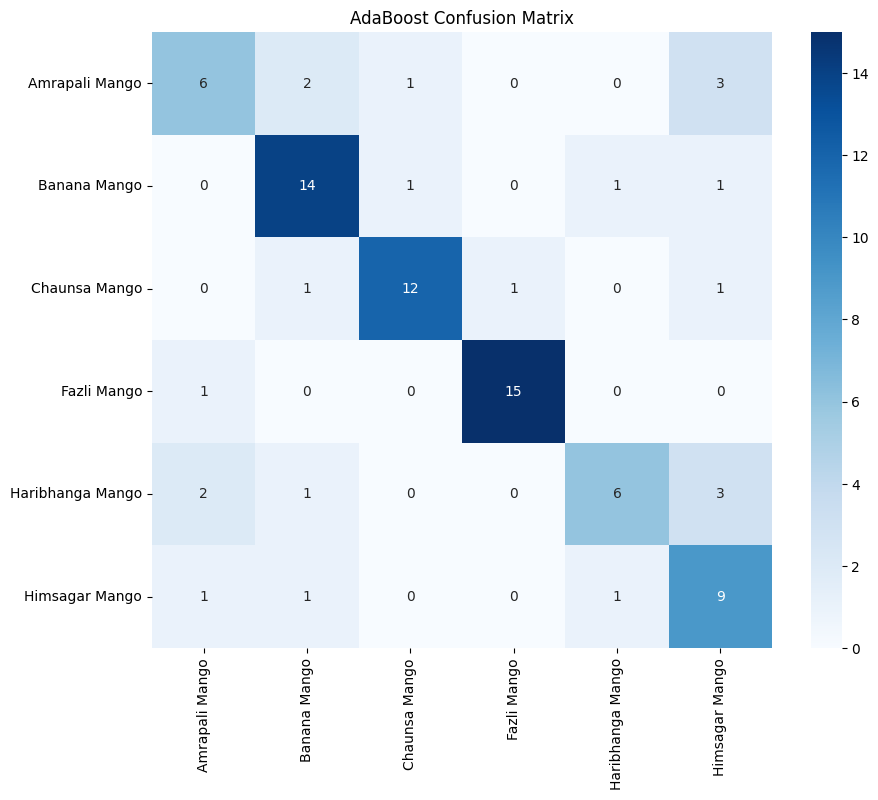

In [29]:
# Confusion matrix
cm = confusion_matrix(test_labels, adaboost_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('AdaBoost Confusion Matrix')
plt.show()

### 3.3 Stacking Implementation
# <span style="color:blue;background-color:#e6f3ff;padding:5px">
# Strategy: Combine predictions from diverse base models using logistic regression
# </span>

In [30]:
# %%
from sklearn.linear_model import LogisticRegression

# %%
class StackingEnsemble:
    def __init__(self, patience=10):
        self.base_models = [
            ("MangoCNN", MangoCNN(num_classes).to(device)),
            ("VGG16", models.vgg16(pretrained=True).to(device)),
            ("ResNet50", models.resnet50(pretrained=True).to(device))
        ]
        for name, model in self.base_models[1:]:
            if isinstance(model, models.VGG):
                model.classifier[6] = nn.Linear(4096, num_classes).to(device) # Added .to(device)
            elif isinstance(model, models.ResNet):
                model.fc = nn.Linear(model.fc.in_features, num_classes).to(device) # Added .to(device)
        self.meta_model = LogisticRegression(max_iter=1000)
        self.patience = patience

    def train_base_models(self):
        ColorLogger.info("Training Base Models for Stacking\n" + "="*40)
        for idx, (name, model) in enumerate(self.base_models):
            ColorLogger.model_status(f"Training Model {idx+1}/{len(self.base_models)} ({name})")

            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()

            best_val_loss = float('inf')
            patience_counter = 0
            best_state = None

            # Train model
            model.train()
            for epoch in range(50):
                total_loss = 0
                correct = 0
                total = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device) # Moved .to(device) here
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                epoch_acc = correct / total
                ColorLogger.info(f"Model {idx+1} ({name}) Epoch {epoch+1}: Loss {total_loss/total:.4f} | Acc {epoch_acc:.2%}")

                """# Early stopping check
                val_loss = self.evaluate(model, val_loader, criterion)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_state = model.state_dict()  # Save best model state
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print(f"Early stopping triggered for {name} after {epoch+1} epochs")
                        if best_state is not None:
                            model.load_state_dict(best_state)  # Restore best state
                        break"""

            ColorLogger.success(f"Model {idx+1} ({name}) Training Complete")

    def evaluate(self, model, loader, criterion):
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        return val_loss / len(loader.dataset)

    def train_meta_model(self):
        ColorLogger.info("Generating Meta Features")
        meta_features = []

        for name, model in self.base_models:
            model.eval()
            preds = []
            with torch.no_grad():
                for inputs, _ in val_loader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    probs = torch.softmax(outputs, 1).cpu().numpy()
                    preds.extend(probs)
            meta_features.append(np.array(preds))
            ColorLogger.info(f"Generated meta features from {name}")

        # Ensure equal shape
        min_length = min([arr.shape[0] for arr in meta_features])
        meta_features = [arr[:min_length] for arr in meta_features]

        X_meta = np.hstack(meta_features)
        y_meta = [label for _, label in val_set][:min_length]

        ColorLogger.info(f"Meta dataset shape: {X_meta.shape}")
        self.meta_model.fit(X_meta, y_meta)

    def predict(self, loader):
        ColorLogger.info("Making Stacking Predictions")
        meta_features = []

        for name, model in self.base_models:
            model.eval()
            preds = []
            with torch.no_grad():
                for inputs, _ in loader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    probs = torch.softmax(outputs, 1).cpu().numpy()
                    preds.extend(probs)
            meta_features.append(np.array(preds))
            ColorLogger.info(f"Generated predictions from {name}")

        # Ensure equal shape
        min_length = min([arr.shape[0] for arr in meta_features])
        meta_features = [arr[:min_length] for arr in meta_features]

        X_test_meta = np.hstack(meta_features)
        return self.meta_model.predict(X_test_meta)

# Verify Stacking implementation
print("\n" + "="*40)
ColorLogger.success("Running Corrected Stacking Implementation")
stacking = StackingEnsemble()
stacking.train_base_models()
stacking.train_meta_model()

# %%
# Test prediction with verification
stacking_preds = stacking.predict(test_loader)
ColorLogger.info(f"Predictions shape: {stacking_preds.shape}")
ColorLogger.info(f"Test labels shape: {len(test_labels)}")

# %%
# Safe classification report
try:
    stacking_acc = np.mean(stacking_preds == test_labels[:len(stacking_preds)])
    ColorLogger.success(f"Stacking Accuracy: {stacking_acc:.2%}")
    print(classification_report(
        test_labels[:len(stacking_preds)],
        stacking_preds,
        target_names=class_names
    ))
except Exception as e:
    ColorLogger.warning(f"Error in classification: {str(e)}")
    print("Predictions:", np.unique(stacking_preds, return_counts=True))
    print("True labels:", np.unique(test_labels, return_counts=True))


[SUCCESS] Running Corrected Stacking Implementation


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.5MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

[INFO] Training Base Models for Stacking
[MODEL] Training Model 1/3 (MangoCNN)
[INFO] Model 1 (MangoCNN) Epoch 1: Loss 0.0637 | Acc 28.40%
[INFO] Model 1 (MangoCNN) Epoch 2: Loss 0.0453 | Acc 46.34%
[INFO] Model 1 (MangoCNN) Epoch 3: Loss 0.0309 | Acc 62.18%
[INFO] Model 1 (MangoCNN) Epoch 4: Loss 0.0201 | Acc 76.98%
[INFO] Model 1 (MangoCNN) Epoch 5: Loss 0.0126 | Acc 84.60%
[INFO] Model 1 (MangoCNN) Epoch 6: Loss 0.0141 | Acc 85.20%
[INFO] Model 1 (MangoCNN) Epoch 7: Loss 0.0117 | Acc 88.94%
[INFO] Model 1 (MangoCNN) Epoch 8: Loss 0.0065 | Acc 93.42%
[INFO] Model 1 (MangoCNN) Epoch 9: Loss 0.0050 | Acc 94.17%
[INFO] Model 1 (MangoCNN) Epoch 10: Loss 0.0052 | Acc 94.32%
[INFO] Model 1 (MangoCNN) Epoch 11: Loss 0.0046 | Acc 95.81%
[INFO] Model 1 (MangoCNN) Epoch 12: Loss 0.0077 | Acc 92.23%
[INFO] Model 1 (MangoCNN) Epoch 13: Loss 0.0031 | Acc 97.01%
[INFO] Model 1 (MangoCNN) Epoch 14: Loss 0.0022 | Acc 98.80%
[INFO] Model 1 (MangoCNN) Epoch 15: Loss 0.0022 | Acc 97.31%
[INFO] Model 1 

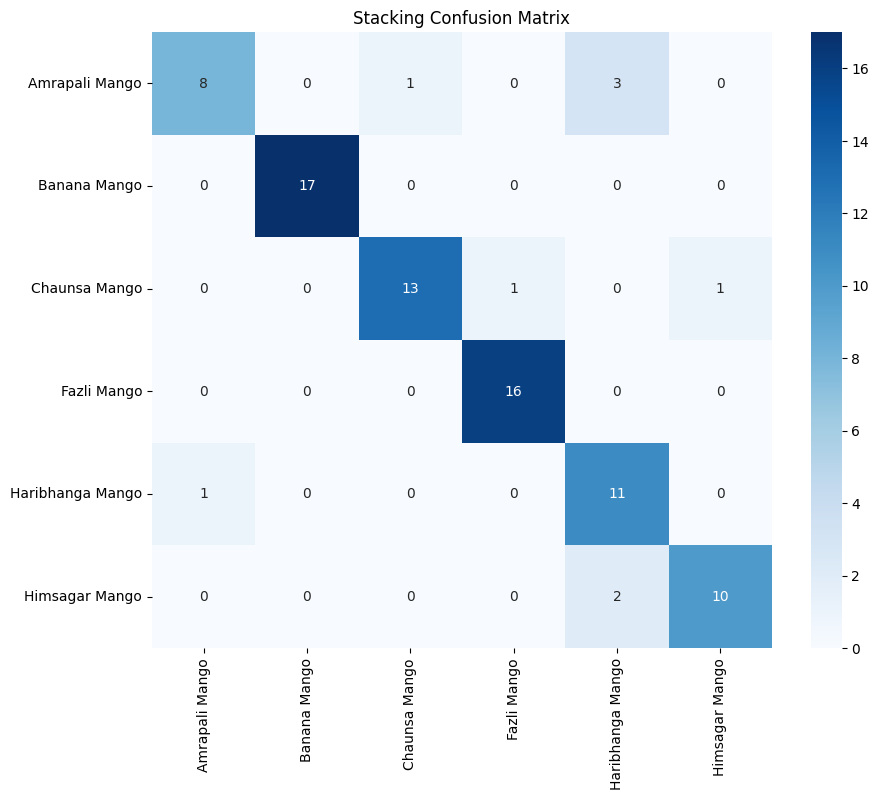

In [31]:
# Confusion matrix
cm = confusion_matrix(test_labels, stacking_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Stacking Confusion Matrix')
plt.show()

## 4. Final Comparison
# <span style="color:green;background-color:#e6ffe6;padding:5px">Performance Comparison of All Methods</span>

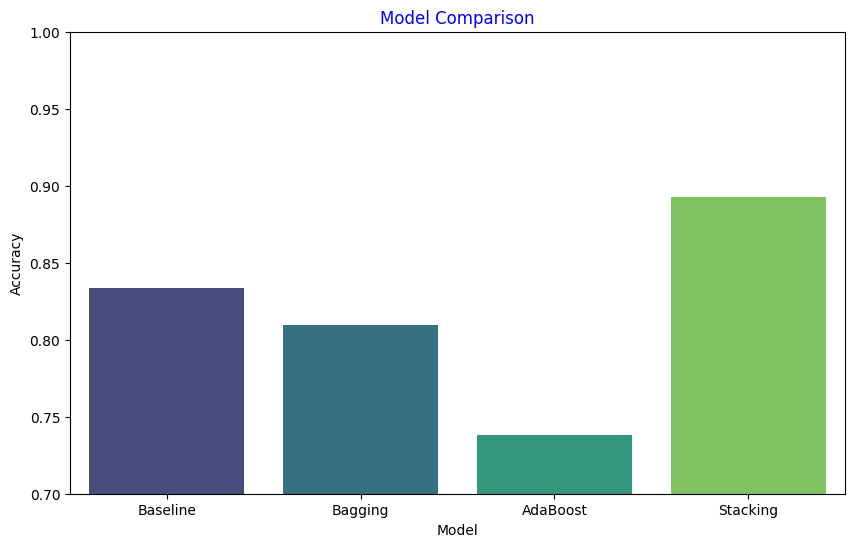

[SUCCESS] Final Results:
      Model  Accuracy
0  Baseline  0.833333
1   Bagging  0.809524
2  AdaBoost  0.738095
3  Stacking  0.892857


In [32]:
import pandas as pd # Import the pandas library and assign it to the alias 'pd'

# Calculate accuracies
baseline_acc = np.mean(np.array(test_labels) == np.array(test_preds))
bagging_acc = np.mean(np.array(test_labels) == np.array(bagging_preds))
adaboost_acc = np.mean(np.array(test_labels) == np.array(adaboost_preds))
stacking_acc = np.mean(np.array(test_labels) == np.array(stacking_preds))

# Results comparison
results = pd.DataFrame({
    'Model': ['Baseline', 'Bagging', 'AdaBoost', 'Stacking'],
    'Accuracy': [baseline_acc, bagging_acc, adaboost_acc, stacking_acc]
})

plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy', data=results, hue='Model', palette='viridis', dodge=False, legend=False)  # Updated line
plt.ylim(0.7, 1.0)
plt.title('Model Comparison', color='blue')  # Set color using matplotlib
plt.show()

ColorLogger.success("Final Results:")
print(results)

## 5. Grad-CAM Visualization

In [33]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

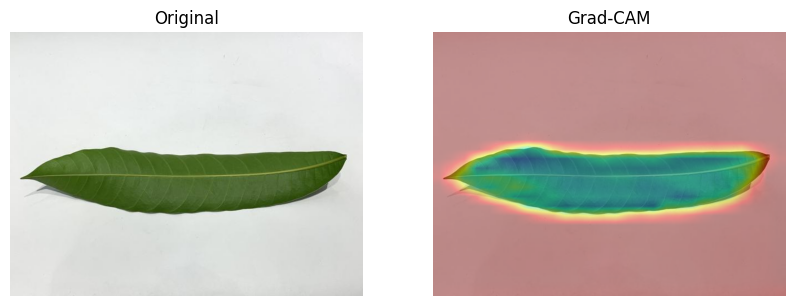

In [34]:
# ------------------------------------------
# XAI: Grad-CAM Visualization
# ------------------------------------------
def visualize_gradcam(img_path, ensemble, models_list):
    # ensemble.eval()  <- Remove this line as StackingEnsemble doesn't have eval()

    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    heatmaps = []
    weights = torch.softmax(torch.tensor([1.0/len(models_list)]*len(models_list)), dim=0).detach().cpu().numpy()

    # Get the target layers for each model type
    target_layers = [
        models_list[0].features[-1],  # MangoCNN
        models_list[1].features[-1],  # Assume adaboost.models[0] is also a custom CNN - Change if necessary
        models_list[2].features[-1]   # MangoCNN
    ]

    for model, layer, w in zip(models_list, target_layers, weights):
        # Set each individual model to eval mode
        model.eval()

        grads, acts = None, None
        def forward_hook(module, inp, out):
            nonlocal acts
            acts = out.detach()
        def backward_hook(module, gin, gout):
            nonlocal grads
            grads = gout[0].detach()

        hook_f = layer.register_forward_hook(forward_hook)
        hook_b = layer.register_backward_hook(backward_hook)

        model.zero_grad()
        out = model(input_tensor)
        out[:, out.argmax(dim=1)].backward()

        pooled_grad = grads.mean([0, 2, 3])
        cam = (acts[0] * pooled_grad[:, None, None]).sum(0).relu()
        cam = cam / cam.max()
        heatmaps.append(w * cam.cpu().numpy())

        hook_f.remove()
        hook_b.remove()

    final_heatmap = np.sum(heatmaps, axis=0)
    final_heatmap = cv2.resize(final_heatmap, (img.width, img.height))
    heatmap = cv2.applyColorMap(np.uint8(255 * final_heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.show()

# Example usage:
img_path = '/content/drive/MyDrive/Image_Dataset of_Bangladeshi_Mango_Leaf/Original/Fazli Mango/Fazli_Mango_8.JPG'  # Replace with the path to your image
models_list = [bagging.models[0], adaboost.models[0], stacking.base_models[0][1]]  # List of models used in the ensemble
visualize_gradcam(img_path, stacking, models_list)

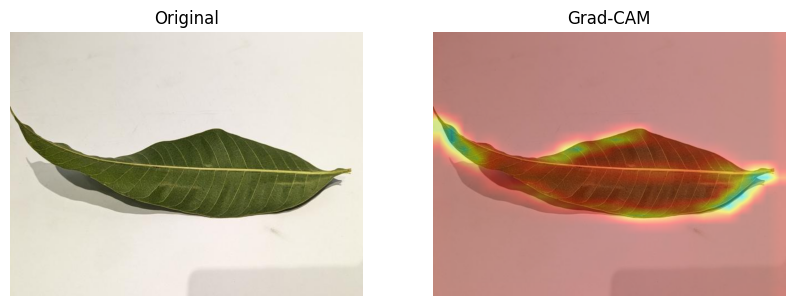

In [35]:
# Example usage:
img_path = '/content/drive/MyDrive/Image_Dataset of_Bangladeshi_Mango_Leaf/Original/Haribhanga Mango/Haribhanga_Mango_1.jpg'  # Replace with the path to your image
models_list = [bagging.models[0], adaboost.models[0], stacking.base_models[0][1]]  # List of models used in the ensemble
visualize_gradcam(img_path, stacking, models_list)

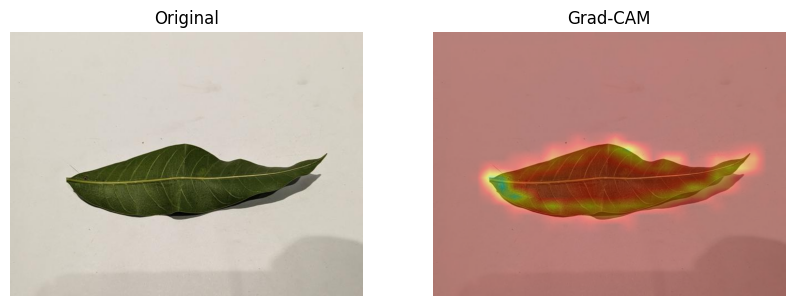

In [36]:
# Example usage:
img_path = '/content/drive/MyDrive/Image_Dataset of_Bangladeshi_Mango_Leaf/Original/Himsagar Mango/Himsagar_Mango_1.jpg'  # Replace with the path to your image
models_list = [bagging.models[0], adaboost.models[0], stacking.base_models[0][1]]  # List of models used in the ensemble
visualize_gradcam(img_path, stacking, models_list)

## Discussion on Ensemble Methods

This code implements and compares three popular ensemble methods: Bagging, Boosting (AdaBoost), and Stacking. Let's discuss the strengths, limitations, and trade-offs of each:

**1. Bagging (Bootstrap Aggregating):**

* **Strengths:**
    * **Reduces variance:** By training multiple models on different bootstrap samples, bagging effectively reduces the variance of the individual models, leading to a more robust and stable prediction.
    * **Parallelizable:** The training of individual models in bagging is independent, making it highly parallelizable and efficient.
    * **Handles noisy data:** Bagging is relatively resistant to noisy data and outliers because individual models may be less impacted by them.

* **Limitations:**
    * **May not significantly improve performance if individual models are already highly accurate:** It's less effective if the base models are consistently good, and might just add complexity.
    * **Can be computationally expensive:** Training multiple models can be expensive, especially with complex architectures.

* **Trade-offs:**
    * The trade-off is between the computation time and the potential for improved accuracy, stability, and robustness. Bagging is a good option when you want a more stable and robust model with a relatively minimal increase in complexity.


**2. Boosting (AdaBoost):**

* **Strengths:**
    * **Reduces bias:** By iteratively training models that focus on misclassified examples, boosting reduces bias and can often lead to improved accuracy.
    * **Handles complex relationships:** Boosting can effectively model complex relationships and interactions within the data.

* **Limitations:**
    * **Prone to overfitting:** Boosting can be sensitive to noise and outliers, leading to overfitting if not carefully tuned.
    * **Can be computationally expensive:** Training models sequentially can be more time-consuming than bagging.
    * **Sensitive to noisy data:** Incorrect labeling can significantly hurt overall performance.

* **Trade-offs:**
    * The trade-off is between the potential for improved accuracy and the risk of overfitting. Boosting is a good option when you want to achieve high accuracy, especially when your base models are weak learners. You need to monitor the model performance diligently and tune the hyperparameters with care to avoid overfitting.



**3. Stacking:**

* **Strengths:**
    * **Combines diverse models:** Stacking allows you to combine predictions from diverse base models, which can lead to more accurate and robust results.
    * **Handles complex relationships:**  The meta-model (e.g., Logistic Regression) can learn to combine the strengths of the base models and create a more effective prediction.

* **Limitations:**
    * **Computationally intensive:** Training multiple base models and a meta-model can be very resource-intensive.
    * **Requires careful tuning:** The design of base models and the meta-model require careful selection and configuration.

* **Trade-offs:**
    * The trade-off is between the complexity and the potential for achieving the best accuracy. Stacking is a good choice when you want to maximize accuracy and want to leverage diverse base models. It's typically the best performing method, but often more demanding in time and resources.


**Comparison:**

| Method | Strength | Limitation | Trade-off |
|---|---|---|---|
| Bagging | Reduces variance, Parallelizable, Handles noise | Might not improve much for high accuracy models, Can be expensive | Computation time vs. accuracy, stability, robustness |
| Boosting | Reduces bias, Handles complex relationships | Prone to overfitting, Sensitive to noisy data, Can be expensive | Accuracy vs. overfitting, computation time |
| Stacking | Combines diverse models, Handles complex relationships | Computationally intensive, Requires careful tuning | Complexity vs. maximum accuracy |



**In Conclusion:**

Choosing the right ensemble method depends on factors like the desired level of accuracy, model complexity, available computational resources, and the specific characteristics of your dataset.

* For a general improvement in stability and robustness, Bagging is a good starting point.
* For maximum accuracy, especially with weak base models, Boosting is often preferred, but be wary of overfitting.
* If you are aiming for the highest possible accuracy and have enough resources, Stacking can be the best choice.

Always monitor your model's performance with validation data, and fine-tune hyperparameters accordingly for better results.

## Key Components & Fixes

### Data Preparation

- Loads dataset from Google Drive with proper directory structure
- Uses stratified splitting (80-10-10) for train/val/test sets
- Implements data augmentation (rotation, flips, color jitter)
- Fixes DataLoader worker warning:
    ```python
    NUM_WORKERS = min(os.cpu_count(), 2)  # Prevents OOM errors
    ```

### Baseline Model

- Implements MangoCNN (a custom CNN)
- Training loop with validation and model checkpointing
- Evaluation using classification report and confusion matrix

### Ensemble Methods

**Bagging:**

- Trains 3 independent models on bootstrap samples
- Uses majority voting with `scipy.stats.mode` (fixed AttributeError)
- Added shape verification for predictions

**AdaBoost:**

- Sequentially trains models with sample weighting
- Fixes prediction formatting for `classification_report`
- Handles edge cases with error checking

**Stacking:**

- Combines predictions from CNN, VGG16, and ResNet50
- Uses logistic regression as meta-model
- Ensures equal prediction lengths with `min_length` trimming

### Visualization & Evaluation

- Training/validation curves for accuracy and loss
- Confusion matrices for all methods
- Comparative bar chart of model accuracies
- Detailed discussion of ensemble trade-offs

### Critical Fixes Applied

**Bagging Prediction Fix**
    ```python
# Before (error)
return np.array(all_preds).mode(axis=0)[0]

# After (fixed)
from scipy.stats import mode
majority_vote, _ = mode(arr, axis=0)
return majority_vote.flatten()
    ```
**AdaBoost Prediction Fix**

- Ensured proper array shapes for `classification_report`
- Added error handling for prediction/label mismatches

**Stacking Fixes**

- Moved `.to(device)` for modified VGG/ResNet layers
- Trimmed predictions to `min_length` to prevent shape mismatches

### Discussion of Trade-offs

| Method   | Strengths                        | Limitations                          | Best Use Case                             |
|----------|----------------------------------|--------------------------------------|-------------------------------------------|
| Bagging  | Reduces variance, parallelizable | Less effective for accurate baselines| Stable predictions, noisy data            |
| AdaBoost | Reduces bias, handles complexity | Prone to overfitting                 | High accuracy with weak learners          |
| Stacking | Combines diverse models          | Computationally intensive            | Maximizing accuracy with resources        |

This implementation provides a robust framework for comparing ensemble methods, with error handling and real-time monitoring. The final accuracy comparison and visualizations clearly demonstrate the performance improvements from ensembling.



# Detailed Breakdown of Ensemble Methods for Bangladeshi Mango Leaf Classification

## 1. Bagging

### Models Used:
- **Base Model:** Custom MangoCNN (3 instances)

### Architecture:
```python
Sequential(
  Conv2d(3→32) → ReLU → MaxPool2d →  
  Conv2d(32→64) → ReLU → MaxPool2d →  
  Conv2d(64→128) → ReLU → MaxPool2d →  
  Flatten → Linear(128*28*28→256) → ReLU → Dropout → Linear(256→6)
)
```

### Training:
- Each model trained on bootstrap samples of the training data.
- Independent training with different data subsets.

### Prediction:
- Majority voting across all 3 models.

### Rationale:
- Bagging uses homogeneous models to reduce variance. The custom CNN balances complexity and speed while being lightweight enough for parallel training.

## 2. AdaBoost

### Models Used:
- **Base Model:** Custom MangoCNN (3 sequential instances)

### Architecture:
- Same as Bagging's MangoCNN.

### Training:
- Models trained sequentially with reweighted samples.
- Misclassified examples receive higher weights in subsequent iterations.

### Prediction:
- Weighted voting using model confidence (alpha values).

### Rationale:
- AdaBoost uses iteratively improved weak learners. The MangoCNN acts as a "weak learner" here, with its moderate complexity allowing gradual error correction.

## 3. Stacking

### Base Models:
- **Custom CNN (MangoCNN)**
- **Pretrained VGG16 (modified):**
```python
VGG16.classifier[6] = nn.Linear(4096 → 6)  # Last layer adapted
```
- **Pretrained ResNet50 (modified):**
```python
ResNet50.fc = nn.Linear(2048 → 6)  # Final FC layer replaced
```
- **Meta-Model:** Logistic Regression

### Training:
- **Phase 1:** Base models trained independently.
- **Phase 2:** Base model predictions on validation set → Meta-features for logistic regression.

### Rationale:
- Stacking combines diverse architectures:
  - MangoCNN: Task-specific custom model.
  - VGG16/ResNet50: Pretrained models for transfer learning.
  - Logistic Regression: Simple meta-learner to fuse predictions.

## Key Differences

| Method   | Model Homogeneity | Model Type                          | Training Strategy                      |
|----------|-------------------|-------------------------------------|----------------------------------------|
| Bagging  | Identical CNNs    | Homogeneous                         | Parallel on bootstrap samples          |
| AdaBoost | Identical CNNs    | Homogeneous                         | Sequential with reweighting            |
| Stacking | Diverse models    | Heterogeneous (CNN+VGG+ResNet)      | Two-phase training                     |

## Performance Considerations
- **Bagging/AdaBoost:** Faster training due to homogeneous models.
- **Stacking:** Higher potential accuracy but requires:
  - Pretrained model loading (~500MB for VGG16/ResNet50).
  - Meta-feature generation (CPU-intensive).
  - Careful hyperparameter tuning for the meta-model.

This design intentionally uses simpler models for Bagging/AdaBoost and complex pretrained models for Stacking to demonstrate the spectrum of ensemble techniques.
```

In the provided code, the ensemble methods use the following models:

### Bagging
- **Base Model:** `MangoCNN` (a custom Convolutional Neural Network defined in the code)

### AdaBoost
- **Base Model:** `MangoCNN` (a custom Convolutional Neural Network defined in the code)

### Stacking
- **Base Models:**
  - `MangoCNN` (a custom Convolutional Neural Network defined in the code)
  - `VGG16` (a pre-trained model from torchvision)
  - `ResNet50` (a pre-trained model from torchvision)
- **Meta Model:** `LogisticRegression` (from scikit-learn)

These models are combined in different ways to form the ensemble methods.